In [74]:
from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla_encoder import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.power.data.meteo import PFDInterFace, ecmwf_new_energy_args, cma_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.power.data.tr import TRInterFace

from finance_utils.electrical2.spot.probabilistic.forecast.power.forecast.gridtwicecook import GridTwiceCookedEncoder


from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import numpy
import pickle
import tqdm
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [75]:
def get_m_time(m:numpy.ndarray):
    print([TimeStamp(i) for i in m[:,0]])

In [76]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

with open(f"{root}\\shanxi_1.pfd", "rb") as f:
    pfd: ProvinceForecastData = pickle.loads(f.read())

In [77]:
gtce = GridTwiceCookedEncoder(
    PFDInterFace.moving_forecast(pfd, "2024-11-11", ["cma", "morning"], "2024-10-1"),
    TRInterFace.hourly_actual_range("shanxi", "2024-10-2", "2024-11-11")["power"],
    "2024-11-11",
    "2024-10-1"
)
gtce.set_batch_size(gtce.days * 4)

In [78]:
[TimeStamp(i) for i in TRInterFace.hourly_actual_range("shanxi", "2024-10-2", "2024-10-21")["timestamp"]]


[TimeStamp(2024, 10, 2, 0, 0),
 TimeStamp(2024, 10, 2, 1, 0),
 TimeStamp(2024, 10, 2, 2, 0),
 TimeStamp(2024, 10, 2, 3, 0),
 TimeStamp(2024, 10, 2, 4, 0),
 TimeStamp(2024, 10, 2, 5, 0),
 TimeStamp(2024, 10, 2, 6, 0),
 TimeStamp(2024, 10, 2, 7, 0),
 TimeStamp(2024, 10, 2, 8, 0),
 TimeStamp(2024, 10, 2, 9, 0),
 TimeStamp(2024, 10, 2, 10, 0),
 TimeStamp(2024, 10, 2, 11, 0),
 TimeStamp(2024, 10, 2, 12, 0),
 TimeStamp(2024, 10, 2, 13, 0),
 TimeStamp(2024, 10, 2, 14, 0),
 TimeStamp(2024, 10, 2, 15, 0),
 TimeStamp(2024, 10, 2, 16, 0),
 TimeStamp(2024, 10, 2, 17, 0),
 TimeStamp(2024, 10, 2, 18, 0),
 TimeStamp(2024, 10, 2, 19, 0),
 TimeStamp(2024, 10, 2, 20, 0),
 TimeStamp(2024, 10, 2, 21, 0),
 TimeStamp(2024, 10, 2, 22, 0),
 TimeStamp(2024, 10, 2, 23, 0),
 TimeStamp(2024, 10, 3, 0, 0),
 TimeStamp(2024, 10, 3, 1, 0),
 TimeStamp(2024, 10, 3, 2, 0),
 TimeStamp(2024, 10, 3, 3, 0),
 TimeStamp(2024, 10, 3, 4, 0),
 TimeStamp(2024, 10, 3, 5, 0),
 TimeStamp(2024, 10, 3, 6, 0),
 TimeStamp(2024, 10, 3, 7

In [79]:
print(gtce.m.shape)
print(gtce.power.shape)

(984, 1132)
(984,)


In [80]:
gtce.grid_and_norm(ZScore, ZScore, cma_new_energy_args)
print(gtce.m.shape)
# for i,g in enumerate(gtce.grid_norm_m):
#     print(g.shape)

(984, 1132)


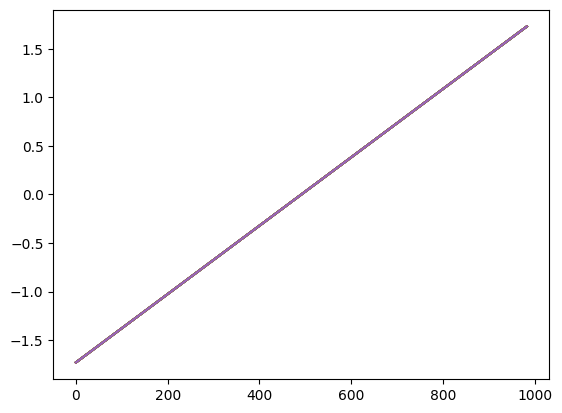

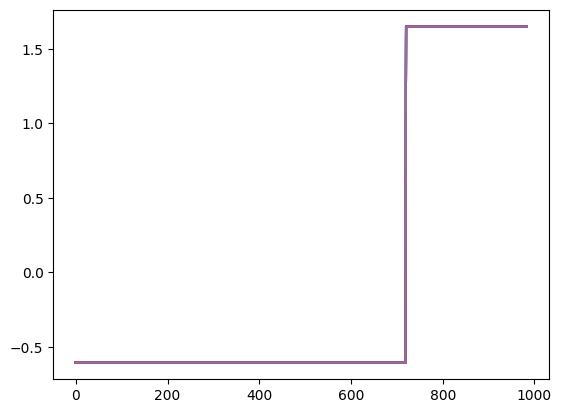

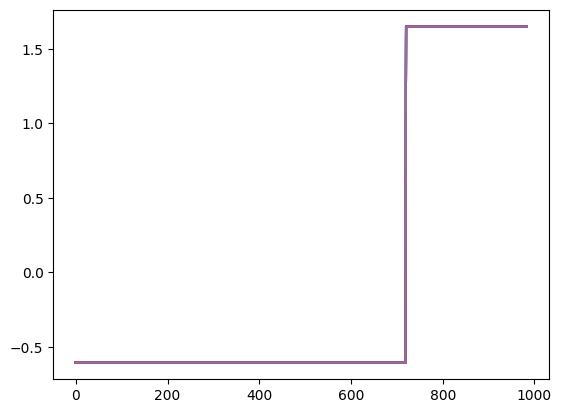

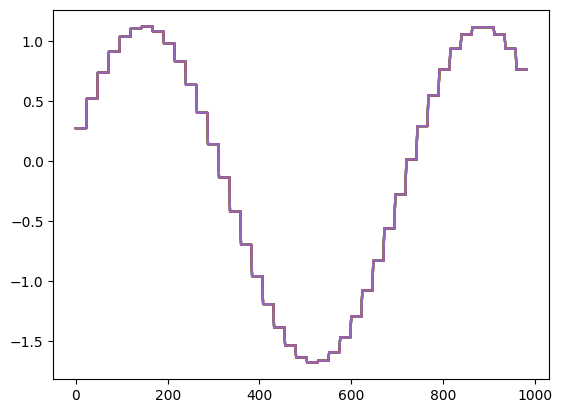

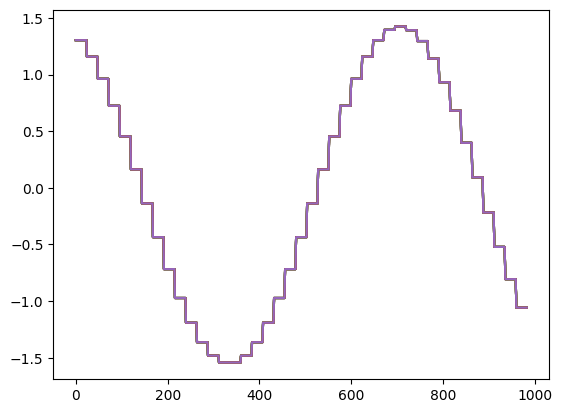

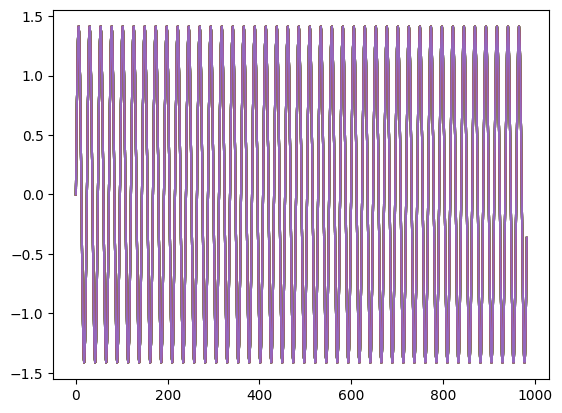

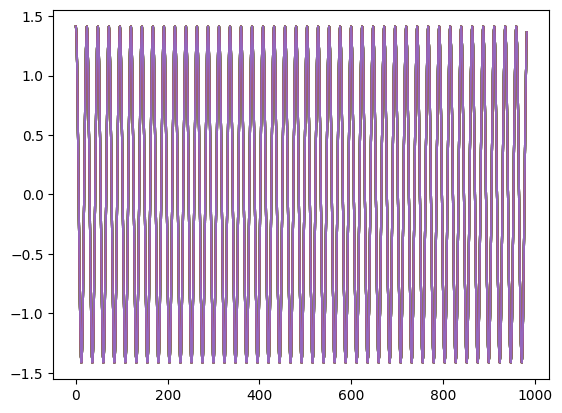

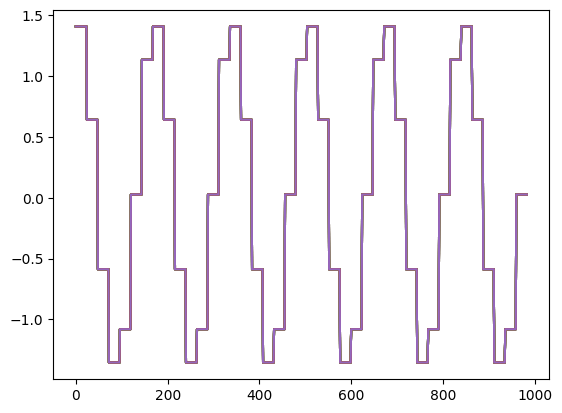

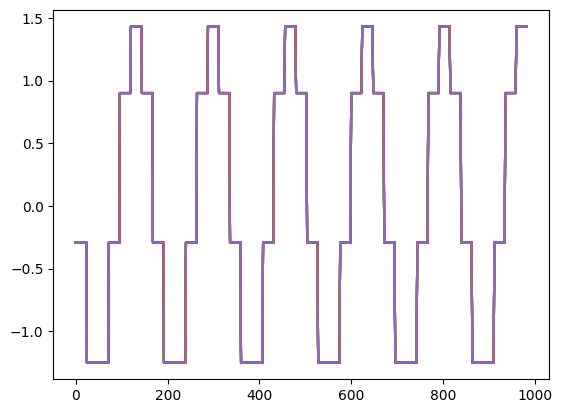

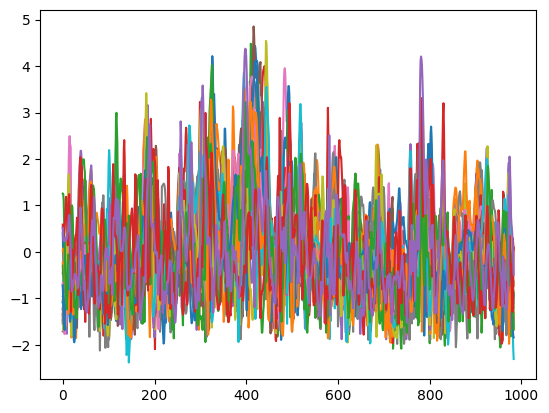

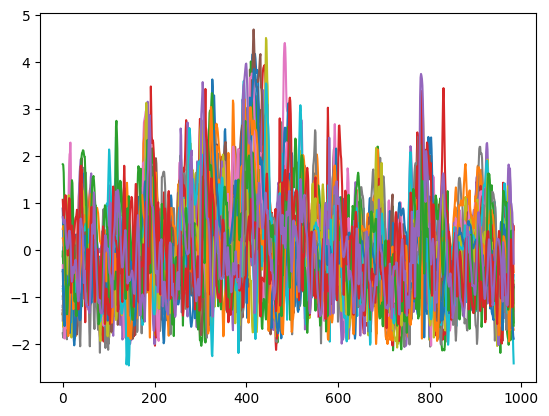

In [81]:
for i in range(11):
    for j in range(len(gtce.grid_norm_m)):
        plt.plot(gtce.grid_norm_m[j][:, i])
    plt.show()

In [82]:
d_model = 128
dim_feedforward = 1024
nhead = 4
output_size = 1
num_layers = 8
lr = 1e-3

gtce.set_batch_size(gtce.days)

gtce.model_train(
    d_model=d_model,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    output_size=output_size,
    num_layers=num_layers,
    lr=lr,
    epoch_num=50,
    dropout=0.1
)

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 50/50 [00:01<00:00, 39.88it/s]


In [83]:
len(gtce.model_list)
# len(PFDInterFace.get_meteo_keys(cma_new_energy_args)[0])

25

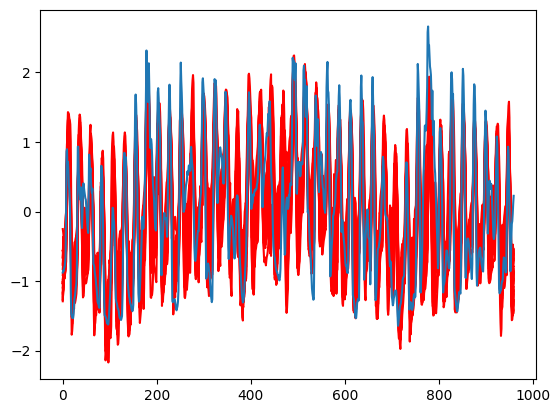

In [84]:
fpd = gtce.first_pot_data()
for i in range(fpd.shape[1]):
    plt.plot(fpd[:,i], color="red")
plt.plot(gtce.train_y)
plt.show()

In [85]:
raw_cook_data = numpy.column_stack((
    gtce.grid_norm_m[0][:-24][:, :gtce.time_dim_len], gtce.first_pot_data(None, [i[:-24] for i in gtce.grid_norm_m])
))
cook_param = []
# cook_data = []
# for i in range(raw_cook_data.shape[1]):
#     cook_param.append(MinMax.params(raw_cook_data[:,i]))
#     # cook_data.append(
#     #     ZScore.f(raw_cook_data[:,i])
#     # )
#     raw_cook_data[:,i] = MinMax.f(raw_cook_data[:,i])



tcm = gtce.twice_cook(
    raw_cook_data,
    batch_size=gtce.days,
    # lr=1e-5,
    epoch_num=100
)

100%|██████████| 100/100 [00:02<00:00, 40.17it/s]


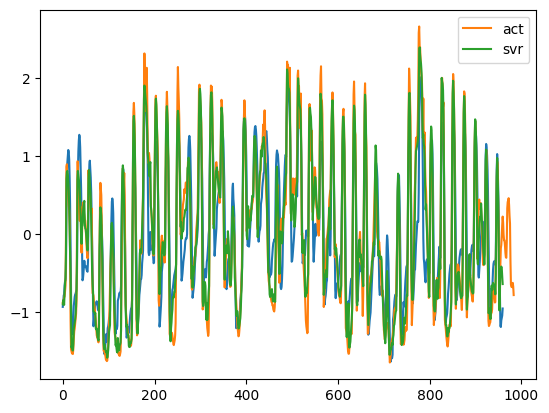

In [86]:
tcm_p = vanilla_transformer_tester(tcm, torch.Tensor(raw_cook_data), gtce.batch_size)
svr = SVR()
svr.fit(raw_cook_data, gtce.train_y)
plt.plot(tcm_p.reshape(-1).cpu().numpy())
plt.plot(
    ZScore.f_with_params(gtce.power, gtce.y_norm_param), label="act"
)
plt.plot(
    svr.predict(raw_cook_data), label="svr"
)
plt.legend()
plt.show()

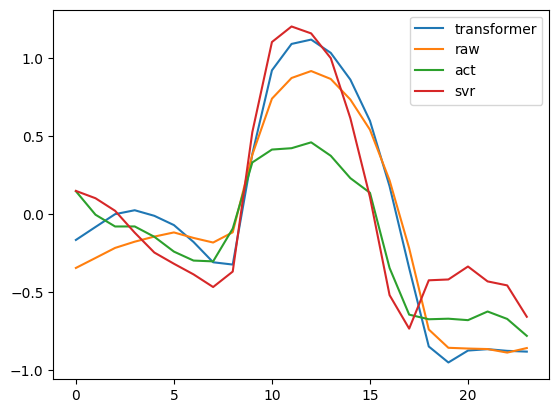

In [87]:
twice_cook_data = numpy.column_stack((
    gtce.grid_norm_m[0][24:][:, :gtce.time_dim_len], gtce.first_pot_data(None, [i[24:] for i in gtce.grid_norm_m])
))
# for i in range(twice_cook_data.shape[1]):
#     twice_cook_data[:,i] = MinMax.f_with_params(twice_cook_data[:,i], p=cook_param[i])


tcm_test = vanilla_transformer_tester(tcm, torch.Tensor(twice_cook_data), gtce.batch_size)

plt.plot(tcm_test.reshape(-1).cpu().numpy()[-24:], label="transformer")
plt.plot(numpy.mean(twice_cook_data[:,gtce.time_dim_len:],axis=1)[-24:], label="raw")
plt.plot(ZScore.f_with_params(gtce.test_power[-24:], gtce.y_norm_param), label="act")
plt.plot(svr.predict(twice_cook_data)[-24:], label="svr")
plt.legend()
plt.show()

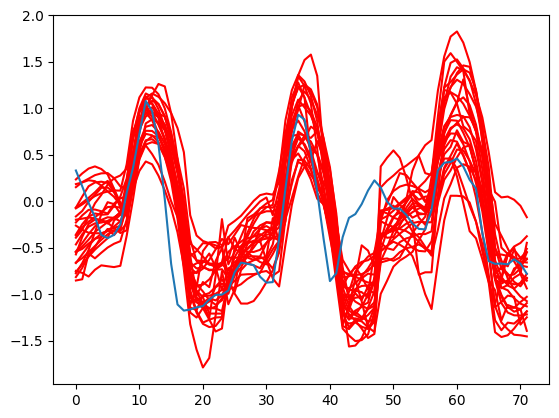

In [88]:
fp_test= gtce.first_pot_data(None, [i[24:] for i in gtce.grid_norm_m])
for i in range(fp_test.shape[1]):
    plt.plot(fp_test[:,i][-24*3:], color="red")
plt.plot(ZScore.f_with_params(gtce.power[-24*3:], gtce.y_norm_param))
plt.show()

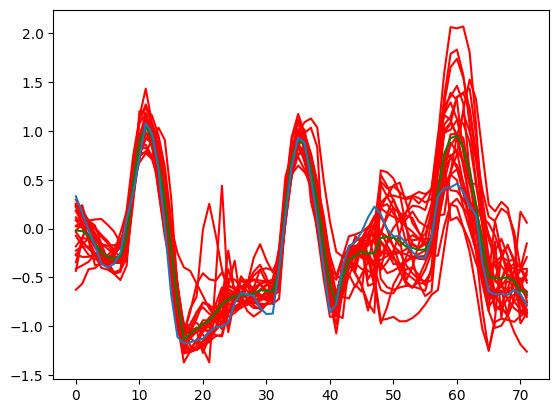

In [89]:
svr_list = []
for i,g in enumerate(gtce.grid_norm_m):
    temp_svr = SVR()
    temp_svr.fit(g[:-24], gtce.train_y)
    svr_list.append(temp_svr.predict(g))
    plt.plot(temp_svr.predict(g)[-24*3:], color="red")
plt.plot(numpy.mean(numpy.array(svr_list).T,axis=1)[-24*3:],color="green")
plt.plot(ZScore.f_with_params(gtce.power, gtce.y_norm_param)[-24*3:])
plt.show() 
    # svr_list.append()


In [90]:
[TimeStamp(i) for i in pfd[["cma", "evening", 1, 1, "2024-10-1"]][:,0]]

[TimeStamp(2024, 10, 2, 0, 0),
 TimeStamp(2024, 10, 2, 1, 0),
 TimeStamp(2024, 10, 2, 2, 0),
 TimeStamp(2024, 10, 2, 3, 0),
 TimeStamp(2024, 10, 2, 4, 0),
 TimeStamp(2024, 10, 2, 5, 0),
 TimeStamp(2024, 10, 2, 6, 0),
 TimeStamp(2024, 10, 2, 7, 0),
 TimeStamp(2024, 10, 2, 8, 0),
 TimeStamp(2024, 10, 2, 9, 0),
 TimeStamp(2024, 10, 2, 10, 0),
 TimeStamp(2024, 10, 2, 11, 0),
 TimeStamp(2024, 10, 2, 12, 0),
 TimeStamp(2024, 10, 2, 13, 0),
 TimeStamp(2024, 10, 2, 14, 0),
 TimeStamp(2024, 10, 2, 15, 0),
 TimeStamp(2024, 10, 2, 16, 0),
 TimeStamp(2024, 10, 2, 17, 0),
 TimeStamp(2024, 10, 2, 18, 0),
 TimeStamp(2024, 10, 2, 19, 0),
 TimeStamp(2024, 10, 2, 20, 0),
 TimeStamp(2024, 10, 2, 21, 0),
 TimeStamp(2024, 10, 2, 22, 0),
 TimeStamp(2024, 10, 2, 23, 0)]

In [91]:
get_m_time(PFDInterFace.grid_separate(gtce.m, cma_new_energy_args)[0][:-24]) 

[TimeStamp(2024, 10, 2, 0, 0), TimeStamp(2024, 10, 2, 1, 0), TimeStamp(2024, 10, 2, 2, 0), TimeStamp(2024, 10, 2, 3, 0), TimeStamp(2024, 10, 2, 4, 0), TimeStamp(2024, 10, 2, 5, 0), TimeStamp(2024, 10, 2, 6, 0), TimeStamp(2024, 10, 2, 7, 0), TimeStamp(2024, 10, 2, 8, 0), TimeStamp(2024, 10, 2, 9, 0), TimeStamp(2024, 10, 2, 10, 0), TimeStamp(2024, 10, 2, 11, 0), TimeStamp(2024, 10, 2, 12, 0), TimeStamp(2024, 10, 2, 13, 0), TimeStamp(2024, 10, 2, 14, 0), TimeStamp(2024, 10, 2, 15, 0), TimeStamp(2024, 10, 2, 16, 0), TimeStamp(2024, 10, 2, 17, 0), TimeStamp(2024, 10, 2, 18, 0), TimeStamp(2024, 10, 2, 19, 0), TimeStamp(2024, 10, 2, 20, 0), TimeStamp(2024, 10, 2, 21, 0), TimeStamp(2024, 10, 2, 22, 0), TimeStamp(2024, 10, 2, 23, 0), TimeStamp(2024, 10, 3, 0, 0), TimeStamp(2024, 10, 3, 1, 0), TimeStamp(2024, 10, 3, 2, 0), TimeStamp(2024, 10, 3, 3, 0), TimeStamp(2024, 10, 3, 4, 0), TimeStamp(2024, 10, 3, 5, 0), TimeStamp(2024, 10, 3, 6, 0), TimeStamp(2024, 10, 3, 7, 0), TimeStamp(2024, 10, 3, 8,